In [226]:
import pickle
from topolearn import *
import numpy as np
import pandas as pd

s = 1
K0_coll = np.arange(5, 26, 4)
nu = 62
# Plot test error curves
curves_params = {"dictionary_type": "separated",
                 "test_error": True, 
                 "prob_T": 0.9, 
                 "sparsity_mode":"random", 
                 "sparsity":25,
                 "mode":"optimistic",
                 "algo_sparsity": K0_coll[s]}

name = f'max_sparsity{curves_params["sparsity"]}' if curves_params["sparsity_mode"]=="max" else f'random_sparsity{curves_params["sparsity"]}'
with open(f'results\\final\\{name}\\res_{curves_params["dictionary_type"]}_T{int(curves_params["prob_T"]*100)}.pkl', "rb") as file:
    models = pickle.load(file)
    res = pickle.load(file)

with open(f"C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\results\\final\\random_sparsity25\\res_separated_T{int(curves_params['prob_T']*100)}_pess.pkl", "rb") as file:
    pess_models = pickle.load(file)
    _ = pickle.load(file)

In [229]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
from topolearn.utils import save_plot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

@save_plot
def plot_changepoints_curve(
    history,
    nu,
    burn_in: float = 0,
    a=0.1,
    b=0.1,
    c=0.9,
    d=0.01,
    yscale: str = "log",
    sparse_plot=False,
    include_burn_in=False,
    change_region_len=3,
    **kwargs,
):

    mode = kwargs.get("mode", "optimistic")
    p = kwargs.get("prob_T")
    k0 = kwargs.get("algo_sparsity")
    T = int(np.ceil(nu * (1 - p)))
    start_iter = 0
    end_iter = 0
    change_points = []
    change_points_y1 = []
    change_points_y2 = []
    burn_in_iter = 0
    his = []
    xx = []
    for i, h in enumerate(history):
        if i == 0:
            burn_in_iter = int(np.ceil(burn_in * len(h)))
        his += h
        end_iter += len(h) - 1
        tmp = range(start_iter, end_iter + 1)
        xx += tmp
        start_iter = end_iter
        change_points.append(end_iter)
        change_points_y1.append(h[-1])
        change_points_y2.append(h[0])

    plt_data = pd.DataFrame({"y": his[burn_in_iter:], "x": xx[burn_in_iter:]})

    change_points = np.array(change_points[:-1])
    change_points_y1 = np.array(change_points_y1[:-1])
    change_points_y2 = np.array(change_points_y2[1:])
    # change_points_y = plt_data[plt_data['x'].isin(change_points)].y.to_numpy()[np.arange(0, len(change_points), 1)]

    my_fig = plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

    my_plt = sns.lineplot(x=plt_data["x"], y=plt_data["y"], estimator=None, sort=False)

    labels = (
        ("removing", "Optimistic")
        if mode == "optimistic"
        else ("adding", "Pessimistic")
    )
    operation = "from" if mode=="optimistic" else "to"
    # Change-points
    sns.scatterplot(
        x=np.hstack([change_points, change_points]),
        y=np.hstack([change_points_y1, change_points_y2]),
        label=f"Change Point: optimally {labels[0]} \n a triangle {operation} Upper Laplacian.",
        color="purple",
        marker="d",
    )

    plt.vlines(
        x=change_points,
        color="lightblue",
        linestyle="dotted",
        ymax=change_points_y1,
        ymin=change_points_y2,
    )

    # Burn-in area
    plt.axvspan(0, burn_in_iter, color="grey", alpha=0.2, hatch="//")

    if include_burn_in:
        x0, xmax = plt.xlim()
    else:
        x0, xmax = plt.xlim()
        x0 = burn_in_iter

    y0, ymax = plt.ylim()

    # my_plt.set_title(f"{labels[1]} topology learning", fontsize=16, pad=25)
    # plt.suptitle(
    #     f"Assumed signal sparsity: {k0}  -  Step size h: {step_h}  -  Step size X: {step_x}",
    #     fontsize=12,
    #     # color="gray",
    #     x=0.5,
    #     y=0.92,
    # )
    if burn_in_iter > 0.:
        plt.text(
            y=ymax * a,
            x=xmax * b,
            s=f"Burn-in: {burn_in_iter} iters.",
            fontsize=15,
            color="gray",
        )
    ni = nu - change_points.shape[0] if mode=="optimistic" else change_points.shape[0]
    
    plt.text(
        s=f" Number of inferred triangles: {ni} \n Number of true triangles: {nu-T}",
        y=ymax * c,
        x=xmax * d,
        fontsize=12,
        color="purple",
    )
    my_plt.set_xlabel("Iteration")

    if sparse_plot:
        tmp_vector = np.ones(len(change_points))
        tmp_vector[1::2] = 0
        plt.xticks(change_points * tmp_vector)
    else:
        if change_points.shape[0] > 1:
            plt.xticks(change_points)
    plt.xlim(left=x0, right=xmax)

    if yscale == "log":
        my_plt.set_ylabel("NMSE (Log Scale)")
        plt.yscale("log")
    else:
        my_plt.set_ylabel("NMSE")

    plt.yticks([])

    # Identify the region where y-values change slowly
    if change_region_len==0:
        y_diff = np.abs(np.diff(plt_data["y"]))
        slow_change_indices = np.where(y_diff < 1e-2)[0]

        if len(slow_change_indices) > 0:
            # Select the first significant region of slow change
            zoom_start = slow_change_indices[0]
            zoom_end = slow_change_indices[-1]

            sns.lineplot(
            x=plt_data["x"].iloc[zoom_start:],
            y=plt_data["y"].iloc[zoom_start:],
            estimator=None,
            sort=False,
            ax=ax_inset,
            )
    elif change_region_len==None:
        pass
    else:
        print(change_points)
        zoom_start = change_points[-change_region_len]
        # zoom_end = len(plt_data["x"])-1
        # Create inset axes for zoomed-in region
        ax_inset = inset_axes(
            my_plt, width="50%", height="40%", loc="center right", borderpad=2
        )
        sns.lineplot(
            x=plt_data["x"].iloc[zoom_start:],
            y=plt_data["y"].iloc[zoom_start:],
            estimator=None,
            sort=False,
            ax=ax_inset,
        )
        # Change-points
        sns.scatterplot(
            x=np.hstack([change_points[-change_region_len:], change_points[-change_region_len:]]),
            y=np.hstack([change_points_y1[-change_region_len:], change_points_y2[-change_region_len:]]),
            color="purple",
            marker="d",
        )


    # Set limits for the zoomed-in region
    # print(zoom_end)
    # print(plt_data["x"].iloc[zoom_end])
    # ax_inset.set_xlim(plt_data["x"].iloc[zoom_start], plt_data["x"].iloc[zoom_end])
    # ax_inset.set_ylim(
    #     plt_data["y"].iloc[zoom_start:].min(),
    #     plt_data["y"].iloc[zoom_start:].max(),
    # )
    ax_inset.set_xlabel(None)
    ax_inset.set_ylabel(None)
    # ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    if yscale == "log":
        ax_inset.set_yscale("log")
    # ax_inset.set_title("Zoomed-in region", fontsize=10)

    return my_fig

[ 21  27  42  46  57  61  69  90  95 100 105 110 115 126 131 145 150 168
 172 184 189 195 200 206 212 216 242 255 266 271]
Plot saved to c:\Users\engri\Desktop\tesi\TSP-DictionaryLearning\plots\final\random_sparsity25\topocp_learning_curve_T50_S9.png


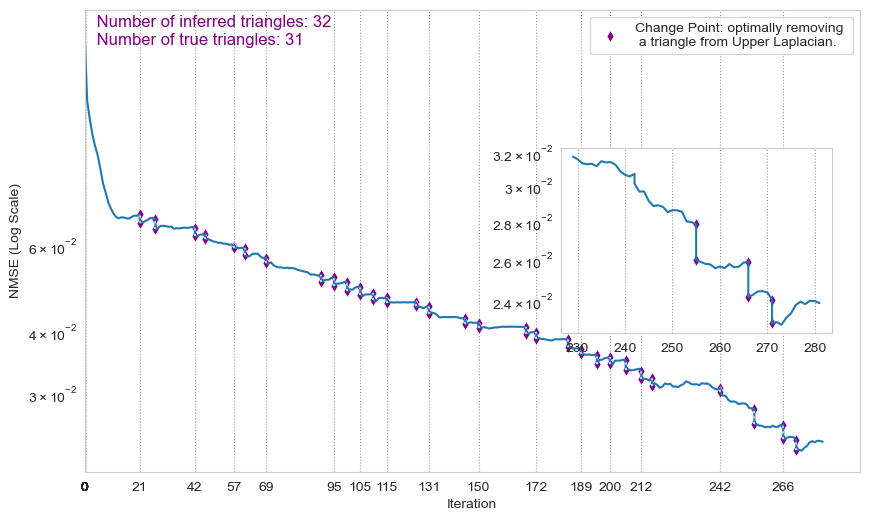

In [223]:
hist = models[f"9,{s}"].train_history

curves_params["mode"] = "optimistic"
plot_changepoints_curve(hist,
                        nu,
                        sparse_plot=True,
                        **curves_params)



[ 33  42  52  57  64  70  79  89  95 110 119 128 136 142 150 164 168 173
 181 190 195 209 218 230 237 242 249 261 272 280 299 311 315 333 337 364
 368 387 391 402 409 413 417 424]
Plot saved to c:\Users\engri\Desktop\tesi\TSP-DictionaryLearning\plots\final\random_sparsity25\topocp_learning_curve_T90_S9_pess.png


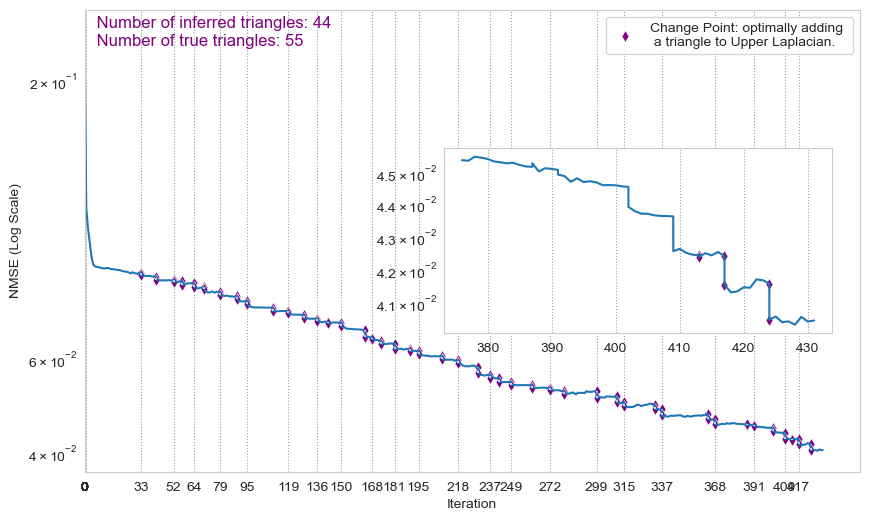

In [230]:
curves_params["mode"] = "pessimistic"
pess_hist = pess_models[(9,s)][0].train_history
plot_changepoints_curve(pess_hist,
                        nu,
                        sparse_plot=True,
                        **curves_params)

In [1]:
from sklearn.model_selection import train_test_split
import scipy.io
import numpy as np
seed = 0
mat = scipy.io.loadmat('real_data\\data_real.mat')
edge_signals = np.array(mat["signal_edge"].T, dtype=float)
valid_signal = np.where(np.sum(edge_signals, axis=1)!=0)
edge_signals = edge_signals[valid_signal]
Y_train, Y_test = train_test_split(edge_signals, test_size=0.2, random_state=seed)
Y_train = Y_train.T
Y_test = Y_test.T
Lu = mat["B2"] @ mat["B2"].T
Ld = mat["B1"].T @ mat["B1"]
L=Lu+Ld
Lu = np.array(Lu, dtype=float)
Ld = np.array(Ld, dtype=float)
L = np.array(L, dtype=float)


In [13]:
import scipy.linalg as sla
vals, _ = sla.eig(L)
c = np.sort(vals)[-1].real*2
epsilon = np.var(vals).real**2

In [14]:
epsilon

23.45782478505993

number of edges: 89

number of triangles: 39

number of nodes: 50

number of examples: 28

In [2]:
from tqdm import tqdm
from topolearn import *
import numpy as np
import warnings
warnings.filterwarnings("ignore")

K0_coll = np.arange(5, 26, 4)

init_params = {
    "J": 2,
    "P": 3,
    "true_prob_T": 1.,
    "n": mat["B1"].shape[0],
    "sparsity": 25,
    "B1_true": mat["B1"],
    "B2_true": mat["B2"]
}

algo_params = {
    "lambda_": 1e-7,
    "tol": 1e-7,
    "patience": 5,
    "max_iter": 100,
    "QP": True,
    "mode": "optimistic",
    "warmup": 2,
    "on_test": False,
    "complete": True,
    "verbose": True,
}

min_error_fou_train = np.zeros((len(K0_coll)))
min_error_fou_test = np.zeros((len(K0_coll)))
min_error_sep_train = np.zeros((len(K0_coll)))
min_error_sep_test = np.zeros((len(K0_coll)))
min_error_edge_train = np.zeros((len(K0_coll)))
min_error_edge_test = np.zeros((len(K0_coll)))
min_error_joint_train = np.zeros((len(K0_coll)))
min_error_joint_test = np.zeros((len(K0_coll)))
min_error_complete_train = np.zeros((len(K0_coll)))
min_error_complete_test = np.zeros((len(K0_coll)))
min_error_pess_train = np.zeros((len(K0_coll)))
min_error_pess_test = np.zeros((len(K0_coll)))
approx_fou = np.zeros((len(K0_coll)))
approx_sep = np.zeros((len(K0_coll)))
approx_joint = np.zeros((len(K0_coll)))
approx_edge = np.zeros((len(K0_coll)))
approx_comp = np.zeros((len(K0_coll)))
approx_pess = np.zeros((len(K0_coll)))

dict_errors = {
    "fourier": (min_error_fou_train, min_error_fou_test, approx_fou),
    "edge": (min_error_edge_train, min_error_edge_test, approx_edge),
    "joint": (min_error_joint_train, min_error_joint_test, approx_joint),
    "separated": (min_error_sep_train, min_error_sep_test, approx_sep),
    "complete": (min_error_complete_train, min_error_complete_test, approx_comp),
    "complete_pess": (min_error_pess_train, min_error_pess_test, approx_pess)
}

dict_types = {
    "fourier": ("Fourier", "fourier"),
    "edge": ("Edge Laplacian", "edge"),
    "joint": ("Hodge Laplacian", "joint"),
    "separated": ("Separated Hodge Laplacian", "separated"),
    # "complete": ("Separated Hodge Laplacian with Topology learning","separated"),
    # "complete_pess": ("Separated Hodge Laplacian with Pessimistic Topology learning","separated"),
}

models = {}

for k0_index, k0 in tqdm(enumerate(K0_coll), leave=False):

    for d in dict_types.items():

        model = TopoSolver(
            X_train=None,
            X_test=None,
            Y_train=Y_train,
            Y_test=Y_test,
            # c=c,
            # epsilon=epsilon,
            K0=k0,
            dictionary_type=d[1][1],
            **init_params,
        )

        learn_topology = True if "complete" in d[0] else False
        if "pess" in d[0]:
            algo_params["mode"]="pessimistic"
        else:
            algo_params["mode"]="optimistic"

        (
            dict_errors[d[0]][0][k0_index],
            dict_errors[d[0]][1][k0_index],
            dict_errors[d[0]][2][k0_index],
        ) = model.fit(
            Lu_true=Lu,
            init_mode="only_X",
            learn_topology=learn_topology,
            **algo_params,
        )

        models[f"{k0_index},{d[0]}"] = model

        print(
            f"Sparsity: {k0} Testing {d[1][0]}... Done! Test Error: {dict_errors[d[0]][1][k0_index]:.6f}"
        )
        print(
            f"Topology Approx. Error: {dict_errors[d[0]][2][k0_index]:.3f}"
        )


0it [00:00, ?it/s]

Sparsity: 5 Testing Fourier... Done! Test Error: 0.610367
Topology Approx. Error: 0.000
Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-10
Best c 59.32942240630018
Best eps 5.730339033953214
Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.071006
Topology Approx. Error: 0.000
Best c 74.98955202318393
Best eps 4.8433325398505644
Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.068728
Topology Approx. Error: 0.000
Best c 74.98955202318393
Best eps 4.8433325398505644


1it [01:51, 111.81s/it]

Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.069215
Topology Approx. Error: 0.000
Sparsity: 9 Testing Fourier... Done! Test Error: 0.481200
Topology Approx. Error: 0.000
Best c 59.32942240630018
Best eps 5.730339033953214
Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.010202
Topology Approx. Error: 0.000
Best c 74.98955202318393
Best eps 4.8433325398505644
Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.009958
Topology Approx. Error: 0.000
Best c 74.98955202318393
Best eps 4.8433325398505644


2it [04:10, 127.46s/it]

Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.010091
Topology Approx. Error: 0.000
Sparsity: 13 Testing Fourier... Done! Test Error: 0.366263
Topology Approx. Error: 0.000


KeyboardInterrupt: 

In [15]:
import pickle

with open("C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\synthetic_data\\random_sparsity25\\full_data_separated.pkl", "rb") as file:
    data = pickle.load(file)
c = data["c_true"].max()
epsilon = data["epsilon_true"].mean()

In [16]:
epsilon

14.648500419151777

In [18]:
import pickle

with open("C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\synthetic_data\\random_sparsity25\\full_data_separated.pkl", "rb") as file:
    data = pickle.load(file)
c = data["c_true"].max()
epsilon = data["epsilon_true"].mean()

K0_coll = np.arange(5, 26, 4)

init_params = {
    "J": 2,
    "P": 3,
    "true_prob_T": 1.,
    "n": mat["B1"].shape[0],
    "sparsity": 25,
    "B1_true": mat["B1"],
    "B2_true": mat["B2"]
}

algo_params = {
    "lambda_": 1e-7,
    "tol": 1e-7,
    "patience": 5,
    "max_iter": 100,
    "QP": True,
    "mode": "optimistic",
    "warmup": 2,
    "on_test": False,
    "complete": True,
    "verbose": True,
}

min_error_fou_train = np.zeros((len(K0_coll)))
min_error_fou_test = np.zeros((len(K0_coll)))
min_error_sep_train = np.zeros((len(K0_coll)))
min_error_sep_test = np.zeros((len(K0_coll)))
min_error_edge_train = np.zeros((len(K0_coll)))
min_error_edge_test = np.zeros((len(K0_coll)))
min_error_joint_train = np.zeros((len(K0_coll)))
min_error_joint_test = np.zeros((len(K0_coll)))
min_error_complete_train = np.zeros((len(K0_coll)))
min_error_complete_test = np.zeros((len(K0_coll)))
min_error_pess_train = np.zeros((len(K0_coll)))
min_error_pess_test = np.zeros((len(K0_coll)))
approx_fou = np.zeros((len(K0_coll)))
approx_sep = np.zeros((len(K0_coll)))
approx_joint = np.zeros((len(K0_coll)))
approx_edge = np.zeros((len(K0_coll)))
approx_comp = np.zeros((len(K0_coll)))
approx_pess = np.zeros((len(K0_coll)))

dict_errors = {
    "fourier": (min_error_fou_train, min_error_fou_test, approx_fou),
    "edge": (min_error_edge_train, min_error_edge_test, approx_edge),
    "joint": (min_error_joint_train, min_error_joint_test, approx_joint),
    "separated": (min_error_sep_train, min_error_sep_test, approx_sep),
    "complete": (min_error_complete_train, min_error_complete_test, approx_comp),
    "complete_pess": (min_error_pess_train, min_error_pess_test, approx_pess)
}

dict_types = {
    "fourier": ("Fourier", "fourier"),
    "edge": ("Edge Laplacian", "edge"),
    "joint": ("Hodge Laplacian", "joint"),
    "separated": ("Separated Hodge Laplacian", "separated"),
    "complete": ("Separated Hodge Laplacian with Topology learning","separated"),
    "complete_pess": ("Separated Hodge Laplacian with Pessimistic Topology learning","separated"),
}

models = {}

for k0_index, k0 in tqdm(enumerate(K0_coll), leave=False):

    for d in dict_types.items():

        model = TopoSolver(
            X_train=None,
            X_test=None,
            Y_train=Y_train,
            Y_test=Y_test,
            c=c,
            epsilon=epsilon,
            K0=k0,
            dictionary_type=d[1][1],
            **init_params,
        )

        learn_topology = True if "complete" in d[0] else False
        if "pess" in d[0]:
            algo_params["mode"]="pessimistic"
        else:
            algo_params["mode"]="optimistic"

        (
            dict_errors[d[0]][0][k0_index],
            dict_errors[d[0]][1][k0_index],
            dict_errors[d[0]][2][k0_index],
        ) = model.fit(
            Lu_true=Lu,
            init_mode="only_X",
            learn_topology=learn_topology,
            **algo_params,
        )

        models[f"{k0_index},{d[0]}"] = model

        print(
            f"Sparsity: {k0} Testing {d[1][0]}... Done! Test Error: {dict_errors[d[0]][1][k0_index]:.6f}"
        )

with open("C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\results\\real.pkl", "wb") as file:
    pickle.dump(models, file)
    pickle.dump(dict_errors, file)

0it [00:00, ?it/s]

Sparsity: 5 Testing Fourier... Done! Test Error: 0.610367
Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.070673
Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.065884
Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.069152
Removing 1 triangles from the topology... 
 ... The min error: 55.000 !
Removing 2 triangles from the topology... 
 ... The min error: 55.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.055 !
Removing 4 triangles from the topology... 
 ... The min error: 0.051 !
Removing 5 triangles from the topology... 
 ... The min error: 0.049 !
Removing 6 triangles from the topology... 
 ... The min error: 0.049 !
Removing 7 triangles from the topology... 
 ... The min error: 0.049 !
Sparsity: 5 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.055610
Adding 1 triangles to the topology... 
 ... The min error: 57.000 !
Adding 2 triangles to the topology... 
 ... The min error: 57.000 !


1it [00:31, 31.91s/it]

Sparsity: 5 Testing Separated Hodge Laplacian with Pessimistic Topology learning... Done! Test Error: 0.070673
Sparsity: 9 Testing Fourier... Done! Test Error: 0.481200
Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.010422
Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.009810
Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.014657
Removing 1 triangles from the topology... 
 ... The min error: 11.000 !
Removing 2 triangles from the topology... 
 ... The min error: 11.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.012 !
Removing 4 triangles from the topology... 
 ... The min error: 0.012 !
Removing 5 triangles from the topology... 
 ... The min error: 0.011 !
Removing 6 triangles from the topology... 
 ... The min error: 0.011 !
Removing 7 triangles from the topology... 
 ... The min error: 0.011 !
Removing 8 triangles from the topology... 
 ... The min error: 0.011 !
Removing 9 triangles from the topology... 
 ... The mi

2it [01:57, 63.28s/it]

Sparsity: 9 Testing Separated Hodge Laplacian with Pessimistic Topology learning... Done! Test Error: 0.010166
Sparsity: 13 Testing Fourier... Done! Test Error: 0.366263
Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.003137
Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.003095
Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.002816
Removing 1 triangles from the topology... 
 ... The min error: 2.000 !
Removing 2 triangles from the topology... 
 ... The min error: 2.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.002 !
Removing 4 triangles from the topology... 
 ... The min error: 0.002 !
Removing 5 triangles from the topology... 
 ... The min error: 0.002 !
Sparsity: 13 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.002615
Adding 1 triangles to the topology... 
 ... The min error: 2.000 !
Adding 2 triangles to the topology... 
 ... The min error: 2.000 !
Adding 3 triangles to the topol

3it [02:59, 63.02s/it]

Sparsity: 13 Testing Separated Hodge Laplacian with Pessimistic Topology learning... Done! Test Error: 0.001668
Sparsity: 17 Testing Fourier... Done! Test Error: 0.284356
Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.001284
Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.001231
Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.001119
Removing 1 triangles from the topology... 
 ... The min error: 0.000 !
Removing 2 triangles from the topology... 
 ... The min error: 0.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.001 !
Removing 4 triangles from the topology... 
 ... The min error: 0.001 !
Removing 5 triangles from the topology... 
 ... The min error: 0.001 !
Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.000993
Adding 1 triangles to the topology... 
 ... The min error: 1.000 !
Adding 2 triangles to the topology... 
 ... The min error: 1.000 !
Adding 3 triangles to the topo

4it [04:50, 81.87s/it]

Sparsity: 17 Testing Separated Hodge Laplacian with Pessimistic Topology learning... Done! Test Error: 0.001693
Sparsity: 21 Testing Fourier... Done! Test Error: 0.217671
Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.000639
Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.001313
Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.000846
Removing 1 triangles from the topology... 
 ... The min error: 0.000 !
Removing 2 triangles from the topology... 
 ... The min error: 0.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.001 !
Removing 4 triangles from the topology... 
 ... The min error: 0.001 !
Removing 5 triangles from the topology... 
 ... The min error: 0.001 !
Removing 6 triangles from the topology... 
 ... The min error: 0.001 !
Removing 7 triangles from the topology... 
 ... The min error: 0.001 !
Removing 8 triangles from the topology... 
 ... The min error: 0.000 !
Removing 9 triangles from the topology... 
 ... The

5it [06:59, 98.90s/it]

Sparsity: 21 Testing Separated Hodge Laplacian with Pessimistic Topology learning... Done! Test Error: 0.000696
Sparsity: 25 Testing Fourier... Done! Test Error: 0.167113
Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.001335
Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.000690
Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.000308
Removing 1 triangles from the topology... 
 ... The min error: 0.000 !
Removing 2 triangles from the topology... 
 ... The min error: 0.000 !
Removing 3 triangles from the topology... 
 ... The min error: 0.000 !
Removing 4 triangles from the topology... 
 ... The min error: 0.000 !
Removing 5 triangles from the topology... 
 ... The min error: 0.000 !
Removing 6 triangles from the topology... 
 ... The min error: 0.000 !
Removing 7 triangles from the topology... 
 ... The min error: 0.000 !
Removing 8 triangles from the topology... 
 ... The min error: 0.000 !
Removing 9 triangles from the topology... 
 ... The

Sparsity: 25 Testing Separated Hodge Laplacian with Pessimistic Topology learning... Done! Test Error: 0.000264


In [1]:
import pickle
from tqdm import tqdm
from topolearn import *
import warnings
from sklearn.model_selection import train_test_split
import scipy.io
import numpy as np
warnings.filterwarnings("ignore")

J=1
P=1

seed = 0
mat = scipy.io.loadmat('real_data\\data_real.mat')
edge_signals = np.array(mat["signal_edge"].T, dtype=float)
valid_signal = np.where(np.sum(edge_signals, axis=1)!=0)
edge_signals = edge_signals[valid_signal]
Y_train, Y_test = train_test_split(edge_signals, test_size=0.2, random_state=seed)
Y_train = Y_train.T
Y_test = Y_test.T
Lu = mat["B2"] @ mat["B2"].T
Ld = mat["B1"].T @ mat["B1"]
L=Lu+Ld
Lu = np.array(Lu, dtype=float)
Ld = np.array(Ld, dtype=float)
L = np.array(L, dtype=float)


with open("C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\synthetic_data\\random_sparsity25\\full_data_separated.pkl", "rb") as file:
    data = pickle.load(file)
c = data["c_true"].max()
epsilon = data["epsilon_true"].mean()

K0_coll = np.arange(5, 26, 4)

init_params = {
    "J": J,
    "P": P,
    "true_prob_T": 1.,
    "n": mat["B1"].shape[0],
    "sparsity": 25,
    "B1_true": mat["B1"],
    "B2_true": mat["B2"]
}

algo_params = {
    "lambda_": 1e-7,
    "tol": 1e-7,
    "patience": 5,
    "max_iter": 100,
    "QP": True,
    "mode": "optimistic",
    "warmup": 2,
    "on_test": False,
    "complete": True,
    "verbose": True,
}

min_error_cfou_train = np.zeros((len(K0_coll)))
min_error_cfou_test = np.zeros((len(K0_coll)))
min_error_fou_train = np.zeros((len(K0_coll)))
min_error_fou_test = np.zeros((len(K0_coll)))
min_error_slep_train = np.zeros((len(K0_coll)))
min_error_slep_test = np.zeros((len(K0_coll)))
min_error_wave_train = np.zeros((len(K0_coll)))
min_error_wave_test = np.zeros((len(K0_coll)))
min_error_sep_train = np.zeros((len(K0_coll)))
min_error_sep_test = np.zeros((len(K0_coll)))
min_error_complete_train = np.zeros((len(K0_coll)))
min_error_complete_test = np.zeros((len(K0_coll)))
min_error_pess_train = np.zeros((len(K0_coll)))
min_error_pess_test = np.zeros((len(K0_coll)))
approx_cfou = np.zeros((len(K0_coll)))
approx_fou = np.zeros((len(K0_coll)))
approx_sep = np.zeros((len(K0_coll)))
approx_slep = np.zeros((len(K0_coll)))
approx_wave = np.zeros((len(K0_coll)))
approx_comp = np.zeros((len(K0_coll)))
approx_pess = np.zeros((len(K0_coll)))

dict_errors = {
    "classic_fourier": (min_error_cfou_train, min_error_cfou_test, approx_cfou),
    "fourier": (min_error_fou_train, min_error_fou_test, approx_fou),
    "slepians": (min_error_slep_train, min_error_slep_test, approx_slep),
    "wavelet": (min_error_wave_train, min_error_wave_test, approx_wave),
    "separated": (min_error_sep_train, min_error_sep_test, approx_sep),
    "complete": (min_error_complete_train, min_error_complete_test, approx_comp),
    "complete_pess": (min_error_pess_train, min_error_pess_test, approx_pess)
}

dict_errors2 = {
    "classic_fourier": min_error_cfou_test,
    "fourier": min_error_fou_test,
    "slepians": min_error_slep_test,
    "wavelet": min_error_wave_test,
    "separated": min_error_sep_test,
    "complete": min_error_complete_test,
    "complete_pess": min_error_pess_test,
}

dict_types = {
    "classic_fourier": ("Fourier", "classic_fourier"),
    "fourier": ("Topological Fourier", "fourier"),
    "slepians": ("Topological Slepians", "slepians"),
    "wavelet": ("Hodgelet", "wavelet"),
    "separated": ("Separated Hodge Laplacian", "separated"),
    "complete": ("Separated Hodge Laplacian with Topology learning","separated"),
    "complete_pess": ("Separated Hodge Laplacian with Pessimistic Topology learning","separated"),
}

models = {}

for k0_index, k0 in tqdm(enumerate(K0_coll), leave=False):

    for d in dict_types.items():

        model = TopoSolver(
            X_train=None,
            X_test=None,
            Y_train=Y_train,
            Y_test=Y_test,
            c=c,
            epsilon=epsilon,
            K0=k0,
            dictionary_type=d[1][1],
            **init_params,
        )

        learn_topology = True if "complete" in d[0] else False
        if "pess" in d[0]:
            algo_params["mode"]="pessimistic"
        else:
            algo_params["mode"]="optimistic"

        (
            dict_errors[d[0]][0][k0_index],
            dict_errors[d[0]][1][k0_index],
            dict_errors[d[0]][2][k0_index],
        ) = model.fit(
            Lu_true=Lu,
            init_mode="only_X",
            learn_topology=learn_topology,
            **algo_params,
        )
        dict_errors2[d[0]] = dict_errors[d[0]][1]
        models[f"{k0_index},{d[0]}"] = model

        print(
            f"Sparsity: {k0} Testing {d[1][0]}... Done! Test Error: {dict_errors[d[0]][1][k0_index]:.6f}"
        )

with open(f"C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\results\\real_J{J}P{P}.pkl", "wb") as file:
    pickle.dump(models, file)
    pickle.dump(dict_errors, file)



0it [00:00, ?it/s]

Sparsity: 5 Testing Fourier... Done! Test Error: 0.777496
Sparsity: 5 Testing Topological Fourier... Done! Test Error: 0.610367
Sparsity: 5 Testing Topological Slepians... Done! Test Error: 0.188351
Sparsity: 5 Testing Hodgelet... Done! Test Error: 0.244725
[[0.]
 [0.]
 [0.]]
(3, 1)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-10
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.076680
[[0.]
 [0.]
 [0.]]
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)


Removing 1 triangles from the topology... 
 ... The min error: 61.000 !
[[5.61181462]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


ValueError: Invalid dimensions (5, 1) for Variable value.

In [155]:
with open("C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\results\\real_final.pkl", "wb") as file:
    pickle.dump(dict_errors2, file)

In [157]:
dict_errors2["fourier"]

array([0.61036654, 0.48119986, 0.36626349, 0.28435608, 0.21767125,
       0.16711314])

In [3]:
np.sum(np.abs(mat["B1"]), axis=0)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])

In [51]:
mat["B2"][:,16]

array([ 1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int16)

In [5]:
l1 = np.unique(np.where(mat["B1"]!=0)[1])

In [4]:
l2 = np.unique(np.where(mat["B2"]!=0)[0])

In [7]:
np.all(l1==l2)

True

In [ ]:
from scipy.fft import fft



In [12]:
import seaborn as sns

colors1 = sns.color_palette()[: len(list(dict_types.keys()))-1]
colors2 = sns.color_palette("Dark2", 5)
colors1[1] = colors2[-2]
colors1[2] = colors2[-1]
colors1 = [colors1[-1]] + colors1[:-1]
# c2 = colors1[0]
# c3 = colors1[-1]
colors1

[(0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

In [13]:
sns.color_palette(colors1)

[(0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

In [16]:
np.where(mat["B2"][:,0]!=0)

(array([ 9, 11, 36], dtype=int64),)

In [18]:
np.where(mat["B1"][:,9]!=0)

(array([ 3, 11], dtype=int64),)

In [20]:
mat["B2"].shape

(89, 39)

In [33]:
A = np.zeros((mat["B1"].shape[0], mat["B1"].shape[0]))
print(A.shape)
edges = np.where(mat["B1"] != 0)
for u, v in zip(edges[0], edges[1]):
    print(u,v)
    A[u,v] = 1
    

(50, 50)
0 0
0 1
0 2
1 3
1 4
1 5
2 6
2 7
2 8
3 9
3 10
3 11
3 12
3 13
4 14
4 15
4 16
4 17
5 14
5 18
5 19
5 20
5 21
6 22
6 23
6 24
7 22
7 25
8 6
8 26
8 27
9 28
9 29
9 30
10 31
10 32
10 33
10 34
11 9
11 26
11 35
11 36
12 37
12 38
13 27
13 35
13 39
13 40
13 41
14 31
14 37
14 42
15 25
15 43
16 28
16 44
16 45
16 46
17 47
17 48
18 44
18 49
18 50


IndexError: index 50 is out of bounds for axis 1 with size 50

In [34]:
edges

(array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,
         4,  5,  5,  5,  5,  5,  6,  6,  6,  7,  7,  8,  8,  8,  9,  9,  9,
        10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14,
        14, 15, 15, 16, 16, 16, 16, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19,
        20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24,
        24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 27, 27, 27, 28, 28, 28,
        28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32,
        33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35, 36, 36, 37, 37, 37, 37,
        38, 38, 38, 38, 39, 39, 39, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43,
        43, 43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 47, 47, 48,
        48, 48, 48, 49, 49, 49, 49, 49], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 14, 18, 19, 20, 21, 22, 23, 24, 22, 25,  6, 26, 27, 28, 29, 30,
        31, 32, 33, 34,  9, 26, 3

In [40]:
A

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

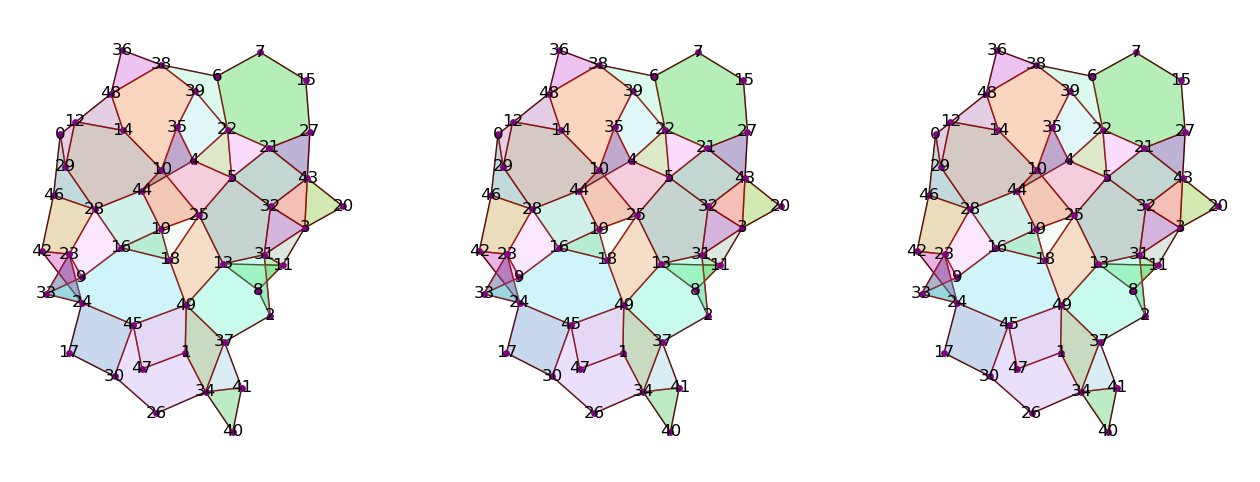

In [148]:
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon as ShapelyPolygon
from matplotlib.patches import Polygon
from networkx.algorithms.cycles import find_cycle

_, axs = plt.subplots(1, 3, figsize=(16, 6))
A = np.zeros((mat["B1"].shape[0], mat["B1"].shape[0]))

for edge_index in range(mat["B1"].shape[1]):
    nodes = np.where(mat["B1"][:, edge_index] != 0)[0]
    A[nodes[0], nodes[1]] = 1

G = nx.from_numpy_array(A)

# Function to sample points along an edge
def sample_edge_points(p1, p2, num_points=100):
    """Returns a set of points sampled along an edge between p1 and p2."""
    return np.linspace(p1, p2, num_points)



for ax in axs:
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="purple", node_size=15, ax=ax)
    for polygon_index in range(mat["B2"].shape[1]):
        np.random.seed(polygon_index)
        color = np.random.rand(3)

        polygon_nodes = np.array([])
        polygon_edges = []
        edges = np.where(mat["B2"][:, polygon_index] != 0)[0]
        
        for edge_index in edges:

            nodes = np.array(np.where(mat["B1"][:, edge_index] != 0)[0], dtype=int)
            polygon_nodes = np.array(np.concatenate((polygon_nodes, nodes)), dtype=int)
            polygon_edges.append(tuple(nodes))

        
        subgraph = G.edge_subgraph(polygon_edges)

        # Find the cycle in the subgraph to get the boundary nodes
        cycle_edges = find_cycle(subgraph)
        polygon_nodes = [pos[edge[0]] for edge in cycle_edges] + [pos[cycle_edges[0][0]]]

        p = Polygon(
            polygon_nodes,
            facecolor=color,
            fill=True,
            edgecolor="red",
            alpha=0.3,
        )
        ax.add_patch(p)




In [151]:
sns.color_palette("viridis")

[(0.275191, 0.194905, 0.496005),
 (0.212395, 0.359683, 0.55171),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.633153, 0.530398),
 (0.288921, 0.758394, 0.428426),
 (0.626579, 0.854645, 0.223353)]

Cycles in the graph: [[2, 6, 1], [3, 4, 6, 1], [5, 4, 6], [3, 5, 6, 1], [2, 3, 1]]


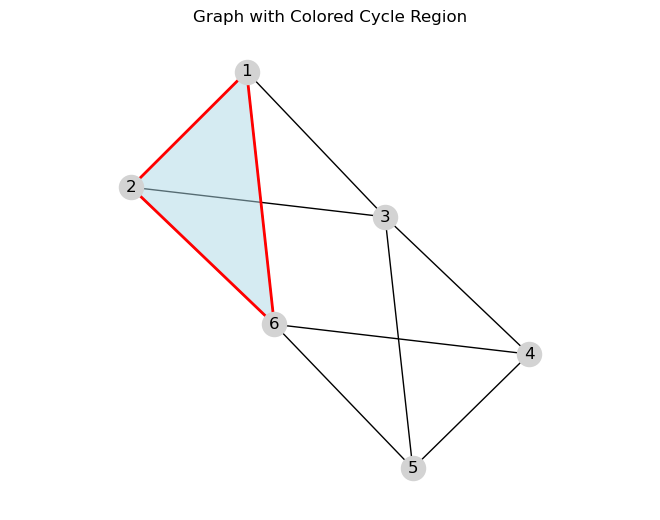

In [101]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create a graph with a complex cycle
G = nx.Graph()
edges = [
    (1, 2), (2, 3), (3, 1), (3, 4), (4, 5), 
    (5, 3), (5, 6), (6, 4), (2, 6), (1, 6)
]
G.add_edges_from(edges)

# Find cycles in the graph
cycles = list(nx.cycle_basis(G))
print("Cycles in the graph:", cycles)

# Select the first cycle for coloring
cycle = cycles[0] if cycles else []

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightgray', edge_color='black')

# Highlight the cycle region
if cycle:
    # Extract the positions of the nodes forming the cycle
    cycle_positions = np.array([pos[node] for node in cycle])
    
    # Ensure that the cycle is closed by repeating the first point
    cycle_positions = np.vstack([cycle_positions, cycle_positions[0]])

    # Fill the area inside the cycle using fill
    plt.fill(cycle_positions[:, 0], cycle_positions[:, 1], color='lightblue', alpha=0.5)

    # Draw the edges of the cycle
    cycle_edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]
    nx.draw_networkx_edges(G, pos, edgelist=cycle_edges, edge_color='red', width=2)

# Show the plot
plt.title("Graph with Colored Cycle Region")
plt.axis('equal')  # Keep aspect ratio equal
plt.show()


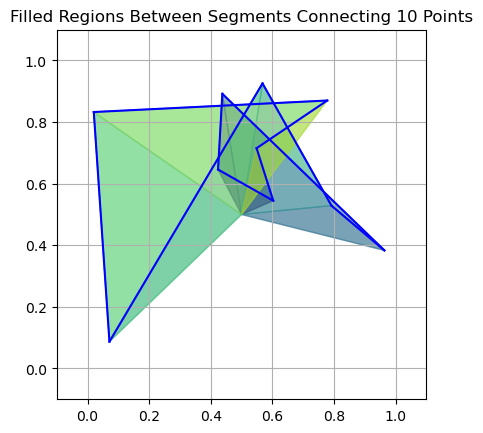

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Generate 10 random points
np.random.seed(0)  # Seed for reproducibility
points = np.random.rand(10, 2)

# Create a figure and axis
plt.figure()
ax = plt.gca()

# Plot the segments between the points
for i in range(len(points)):
    # Current point
    point1 = points[i]
    # Next point (wrapping around to the start)
    point2 = points[(i + 1) % len(points)]
    
    # Draw line segments
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'b-')  # Blue lines connecting points

# Fill the polygon formed by all points
polygon = plt.Polygon(points, closed=True, fill=True, edgecolor='blue', facecolor='lightgreen', alpha=0.5)
ax.add_patch(polygon)

# Create and fill regions between each segment
for i in range(len(points)):
    next_index = (i + 1) % len(points)  # Wrap around for the last segment
    # Define the vertices for the triangular regions
    triangle = np.array([points[i], points[next_index], [0.5, 0.5]])  # Example point in the center
    ax.add_patch(plt.Polygon(triangle, color=plt.cm.viridis(i / len(points)), alpha=0.4))  # Color regions differently

# Set plot limits and show
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Filled Regions Between Segments Connecting 10 Points')
plt.grid(True)
plt.show()
